In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import time

import sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix, f1_score

import random, os, json
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, GRU, Dropout, Dense
from tensorflow.keras import backend as K

import sys
sys.path.append("../")
import utils_models 
import utils_interpretability

from joblib import Parallel, delayed
import multiprocessing

import pickle

In [2]:
n_time_steps = 14
norm = "robustNorm"

# EXPLAINABILITY.  IT-SHAP

In [3]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def load_from_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

def save_to_pickle(data, filename):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)
        
def plot_shap(results, reordered_indices, title, save_img=False):
    """
    Heatmap plot based on IT-SHAP values from 'results', reordered
    according to 'reordered_indices', saved as .pdf with the name indicated in 'title'

    - results: List of pandas DataFrames containing SHAP values.
    - reordered_indices: List of indices to reorder the data.
    - title: str title to save the plot.
    """
    df_conc = pd.concat(results)

    df_mean_pats = pd.DataFrame(columns=np.arange(1, 15, 1))
    for i in range(len(features)):
        df_mean_pats.loc[i] = df_conc[df_conc.index == features[i]].mean()

    # Order the time steps and the features 
    cols = df_mean_pats.columns.tolist()
    time_order = cols[::-1]
    df_final = df_mean_pats[time_order]
    df_final.columns = np.arange(0, 14, 1)

    reordered_data = df_final.iloc[reordered_indices, :]
    
    data_max = reordered_data.values.max()
    data_min = reordered_data.values.min()

    # Heatmap
    plt.figure(figsize=(11,22))
    ax = plt.gca()
    heatmap = sns.heatmap(
        reordered_data, 
        cmap="viridis", 
        xticklabels=np.arange(14) + 1,
        yticklabels=new_order,
        ax=ax,
        cbar=False  # Disable the default color bar
    )
    
    heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=22)
    heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=22, rotation=90)
    
    # Create colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = heatmap.figure.colorbar(heatmap.collections[0], cax=cax)
    cbar.ax.tick_params(labelsize=22)
    
    num_ticks = 9
    tick_locs = np.linspace(data_min, data_max, num_ticks)
    cbar.set_ticks(tick_locs)
    cbar.set_ticklabels([f'{tick:.3f}' for tick in tick_locs])
    cbar.ax.tick_params(labelsize=22)

    plt.tight_layout(pad=0)
    if save_img == True:
        plt.savefig(title, bbox_inches='tight', pad_inches=0) 

    plt.show()
    
    return reordered_data

def plot_shap_norm(matrix_amr, matrix_noamr, reordered_indices, title, save_img=False): 
    """
    Heatmap plot based on IT-SHAP values from 'results', normalized to have the indices of AMR, reordered
    according to 'reordered_indices', saved as .pdf with the name indicated in 'title'    
    """

    min_amr, max_amr = matrix_amr.min().min(), matrix_amr.max().max()
    min_noamr, max_noamr = matrix_noamr.min().min(), matrix_noamr.max().max()
    
    matrix_noamr_transformed = (matrix_noamr - min_noamr) / (max_noamr - min_noamr) * (max_amr - min_amr) + min_amr
    
    data_max = matrix_noamr_transformed.values.max()
    data_min = matrix_noamr_transformed.values.min()

    plt.figure(figsize=(11,22))
    ax = plt.gca()
    heatmap = sns.heatmap(
        matrix_noamr_transformed, 
        cmap="viridis", 
        xticklabels=np.arange(14) + 1,
        yticklabels=new_order,
        ax=ax,
        cbar=False  # Disable the default color bar
    )
    
    heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=22)
    heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=22, rotation=90)

    # Create colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = heatmap.figure.colorbar(heatmap.collections[0], cax=cax)
    cbar.ax.tick_params(labelsize=22)
    
    num_ticks = 9
    tick_locs = np.linspace(data_min, data_max, num_ticks)
    cbar.set_ticks(tick_locs)
    cbar.set_ticklabels([f'{tick:.3f}' for tick in tick_locs])
    cbar.ax.tick_params(labelsize=22)

    plt.tight_layout(pad=0)
    if save_img == True:
        plt.savefig(title, bbox_inches='tight', pad_inches=0) 

    plt.show()


In [4]:
features =  ['AMG', 'CAR', 'CF1', 'CF3', 'CF4',
            'Others', 'GLI', 'LIN', 'LIP', 'MAC', 'NTI', 'OXA', 'PAP', 'PEN', 'POL',
            'QUI', 'SUL', 'MV hours', 'Acinet$_{pc}$', 'Enterobac$_{pc}$', 'Enteroc$_{pc}$',
            'Pseud$_{pc}$', 'Staph$_{pc}$', 'Others$_{pc}$', 'ICU$_{hours}$',
            '# pat$_{atb}$', '# pat$_{MDR}$',
            'CAR$_{n}$', 'PAP$_{n}$', 
            'Others$_{n}$', 'QUI$_{n}$',
            'OXA$_{n}$', 'PEN$_{n}$', 'CF3$_{n}$', 'GLI$_{n}$',
            'CF4$_{n}$', 'SUL$_{n}$', 'NTI$_{n}$', 'LIN$_{n}$',
            'AMG$_{n}$', 'MAC$_{n}$', 'CF1$_{n}$', 'POL$_{n}$',
            'LIP$_{n}$', '# pat$_{tot}$' ,'Post change',
            'Insulin', 'Art nutrition', 'Sedation', 'Relax', 'Hepatic$_{fail}$',
            'Renal$_{fail}$', 'Coagulation$_{fail}$', 'Hemodynamic$_{fail}$',
            'Respiratory$_{fail}$', 'Multiorganic$_{fail}$',  '# transfusions',
            'Vasoactive drug', 'Dosis nems', 'Tracheo$_{hours}$', 'Ulcer$_{hours}$',
            'Hemo$_{hours}$', 'C01 PIVC 1',
            'C01 PIVC 2', 'C02 CVC - RJ',
            'C02 CVC - RS', 'C02 CVC - LS', 'C02 CVC - RF',
            'C02 CVC - LJ', 'C02 CVC - LF', '# catheters']

# Show the features in the plot with a clinical order

new_order = ['AMG', 'CAR', 'CF1', 'CF3', 'CF4',
            'Others', 'GLI', 'LIN', 'LIP', 'MAC', 'NTI', 'OXA', 'PAP', 'PEN', 'POL',
            'QUI', 'SUL','# pat$_{atb}$', '# pat$_{MDR}$', '# pat$_{tot}$', 'CAR$_{n}$', 'PAP$_{n}$', 
            'Others$_{n}$', 'QUI$_{n}$',
            'OXA$_{n}$', 'PEN$_{n}$', 'CF3$_{n}$', 'GLI$_{n}$',
            'CF4$_{n}$', 'SUL$_{n}$', 'NTI$_{n}$', 'LIN$_{n}$',
            'AMG$_{n}$', 'MAC$_{n}$', 'CF1$_{n}$', 'POL$_{n}$',
            'LIP$_{n}$', 'Acinet$_{pc}$', 'Enterobac$_{pc}$', 'Enteroc$_{pc}$',
            'Pseud$_{pc}$', 'Staph$_{pc}$', 'Others$_{pc}$',
            'Post change',
            'Insulin', 'Art nutrition', 'Sedation', 'Relax', 'MV hours', 'Respiratory$_{fail}$','Hepatic$_{fail}$',
            'Renal$_{fail}$', 'Coagulation$_{fail}$', 'Hemodynamic$_{fail}$',
            'Multiorganic$_{fail}$', '# transfusions',
            'Vasoactive drug', 'Dosis nems', 'Tracheo$_{hours}$', 'Ulcer$_{hours}$',
            'Hemo$_{hours}$', 'ICU$_{hours}$', 'C01 PIVC 1',
            'C01 PIVC 2', 'C02 CVC - RJ',
            'C02 CVC - RS', 'C02 CVC - LS', 'C02 CVC - RF',
            'C02 CVC - LJ', 'C02 CVC - LF', '# catheters']

feature_idx = {feature: idx for idx, feature in enumerate(features)}
reordered_indices = [feature_idx[feature] for feature in new_order]

## Load each split and model and save the IT-SHAP values

In [ ]:
import TFWrapper, XAI_utils
from IT_SHAP import local_report
from tensorflow.keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt

############################################################################
# Parameteres to define
directory = './Results_GRU'

# "s1", "s2", "s3"
split = "s3"
# "model_0", "model_1", "model_2"
model = load_model('./Results_GRU/model_2.h5')
numberOftrPat = 1000
norm = "robustNorm"
numberOfTimeSteps = 14
nsamples = 3200
############################################################################

# Step 0. Create the wrapper
model_wrapped = TFWrapper.KerasModelWrapper(model)
f_hs = lambda x, y=None: model_wrapped.predict_last_hs(x, y)

# Step 1. Load data
X_train = np.load(f"../../DATA/BBCET_cult_ok_19062024/{split}/X_train_tensor_0{norm}.npy")
X_test = np.load(f"../../DATA/BBCET_cult_ok_19062024/{split}/X_test_tensor_{norm}.npy")
y_test = pd.read_csv(f"../../DATA/BBCET_cult_ok_19062024/{split}/y_test_tensor_"+norm+".csv")

# Step 2. Create dataframe of train data
data = X_train[0:numberOftrPat]
df = pd.DataFrame(data.reshape(-1, data.shape[-1]), columns=features)

adb_column = []
for i in range(int(df.shape[0]/numberOfTimeSteps)):
    adb_column.extend([f'adb_{i}'] * numberOfTimeSteps)
df['adb'] = adb_column

# Add the column timeStep
time_step_column = []
for i in range(int(df.shape[0]/numberOfTimeSteps)):
    time_step_column.extend(list(range(numberOfTimeSteps)))
df['timestamp'] = time_step_column
d_train_normalized = df.copy()


# Step 3. Get average of event and sequence
average_event = XAI_utils.calc_avg_event(d_train_normalized, numerical_feats=features)
average_sequence = XAI_utils.calc_avg_sequence(d_train_normalized, numerical_feats=features, model_features=features, entity_col="adb")

In [ ]:
# Step 4. Running shap for X_test patients
results_shap = []
ign_pat = []
for idx_pat in range(X_test.shape[0]):
    print("===>", idx_pat)
    X = X_test[idx_pat]
    rows_filtered = np.any(X == 666, axis=-1)
    if len(rows_filtered[rows_filtered == False]) == 1:
        ign_pat.append(idx_pat)
        continue
        
    pos_x_data = np.expand_dims(X, axis=0)
    X_aux = X[:,~rows_filtered[0], :]

    event_dict = {'rs': 25, 'nsamples': nsamples}
    feature_dict = {'rs': 25, 'nsamples': nsamples, 'feature_names': features, 'plot_features': None}
    cell_dict = {'rs': 25, 'nsamples': nsamples, 'top_x_feats': pos_x_data.shape[2], 'top_x_events': X_aux.shape[1]}

    # local report with numpy instance ~ average_event
    _, _, cell_levelr = local_report(f_hs, pos_x_data, None, event_dict, feature_dict, 
                                     cell_dict=cell_dict, entity_uuid="adb", entity_col='adb', baseline=average_event)

    # reformat the dataframe always in the same order
    df = cell_levelr.copy()

    # Process the 'Event' column to get just the numbers
    df['Event'] = df['Event'].str.extract(r'(\d+)').astype(int)

    # Create a pivot table for the heat map
    pivot_table = df.pivot_table(index='Feature', columns='Event', values='Shapley Value', fill_value=0)
    pivot_table = pivot_table.reset_index()
    pivot_table.index = pivot_table['Feature'].values
    pivot_table = pivot_table.drop(['Feature'], axis=1)

    indices_actuales = list(pivot_table.index)
    posicion_indices = {indice: posicion for posicion, indice in enumerate(indices_actuales)}
    posiciones_reordenadas = [posicion_indices[indice] for indice in features]
    df_final = pivot_table.reindex(index=[indices_actuales[posicion] for posicion in posiciones_reordenadas])
    results_shap.append(df_final)
    
save_to_pickle(results_shap, os.path.join(directory, f"results_shap_{split}.pkl"))

# SPLIT 1

In [5]:
directory = './Results_GRU'
split = "s1"
norm = "robustNorm"

### POPULATION

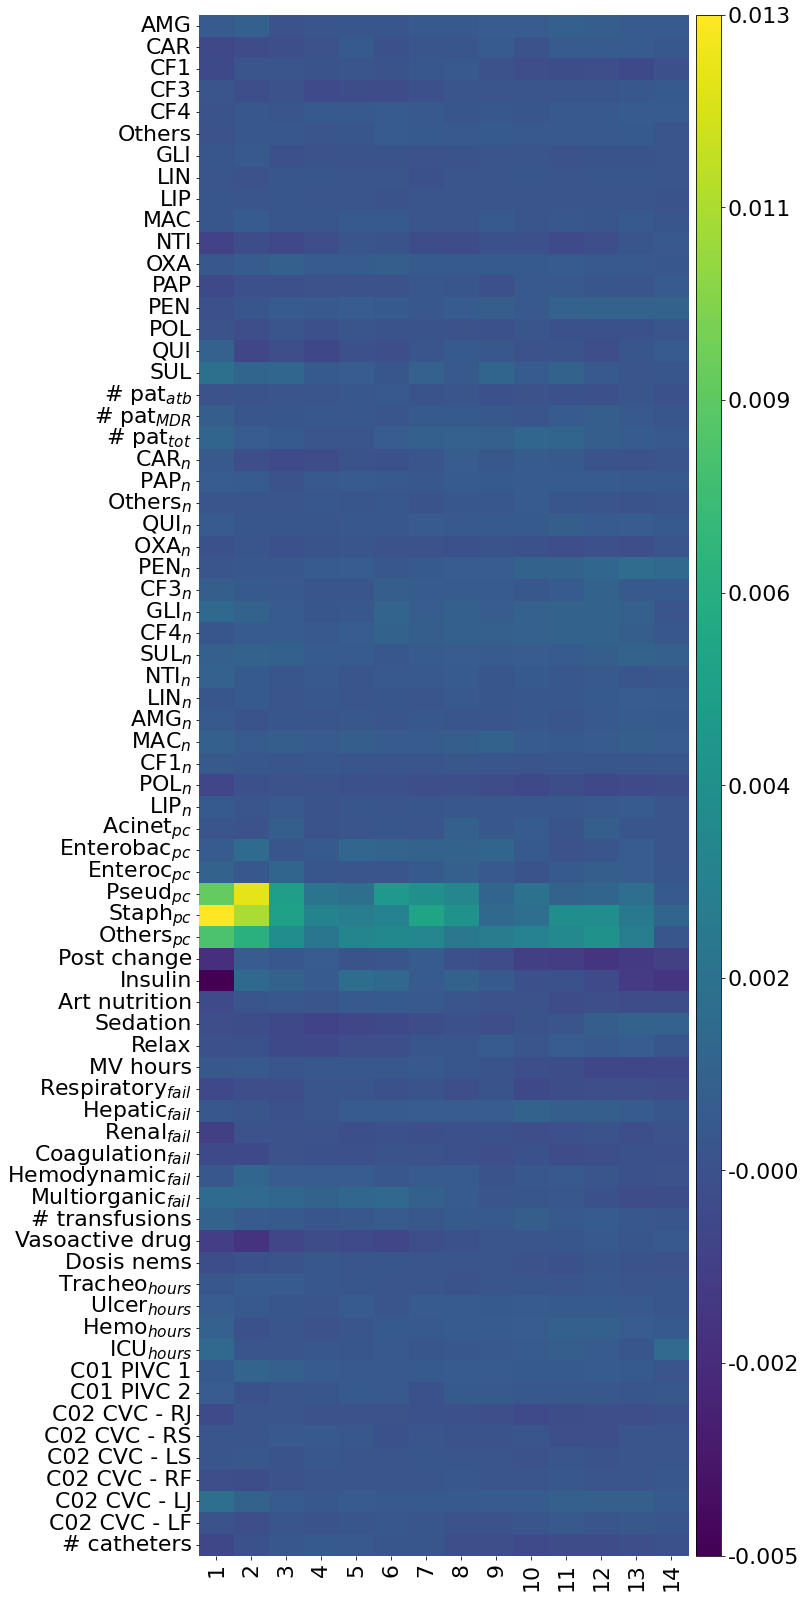

In [6]:
split_shap = load_from_pickle(os.path.join(directory, f"results_shap_{split}.pkl"))
matrix_pop = plot_shap(split_shap, reordered_indices, f"../Figures_VF/SHAP_{split}_population.pdf", save_img=True)

### MDR PATIENTS

In [7]:
ign_pat = []
X_test = np.load(f"../../DATA/BBCET_cult_ok_19062024/{split}/X_test_tensor_{norm}.npy")
for idx_pat in range(X_test.shape[0]):
    X = X_test[idx_pat]
    rows_filtered = np.any(X == 666, axis=-1)
    if len(rows_filtered[rows_filtered == False]) == 1:
        ign_pat.append(idx_pat)
        
y_test = pd.read_csv(f"../../DATA/BBCET_cult_ok_19062024/{split}/y_test_tensor_{norm}.csv")
y_test_f = y_test.loc[:, 'individualMRGerm'].values.reshape(y_test.shape[0] // n_time_steps, n_time_steps)
y_test_f = np.delete(y_test_f, ign_pat, axis=0)
y_test_f.shape

(1041, 14)

In [8]:
import copy
list_of_dfs = copy.deepcopy(split_shap)
array_pacientes = y_test_f

split_shap_amr = []

for i in range(len(list_of_dfs)):
    patient_shap = list_of_dfs[i]
    amr_status = array_pacientes[i]  

    for col in patient_shap.columns:
        if amr_status[col - 1] == 0:
            patient_shap.loc[:, col] = np.nan #NonAMR patients are set to Nan
        else:
            patient_shap.loc[:, col] = patient_shap.loc[:, col] #AMR patients keep the info

    split_shap_amr.append(patient_shap)


**Visualize the MDR data without normalization**

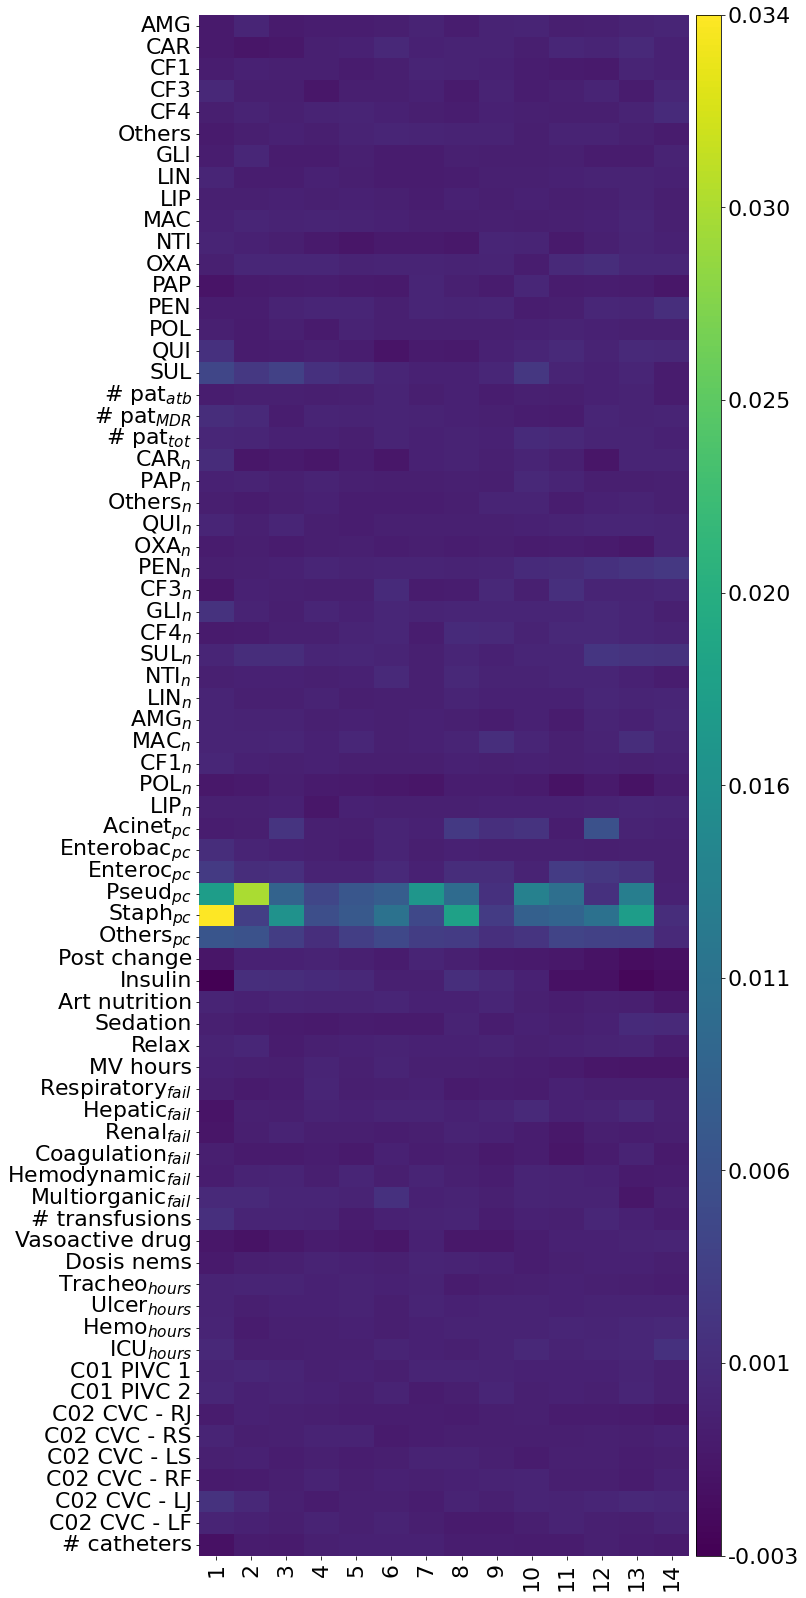

In [9]:
matrix_amr = plot_shap(split_shap_amr, reordered_indices, f"", save_img=False)

**Visualize the MDR data with normalization**

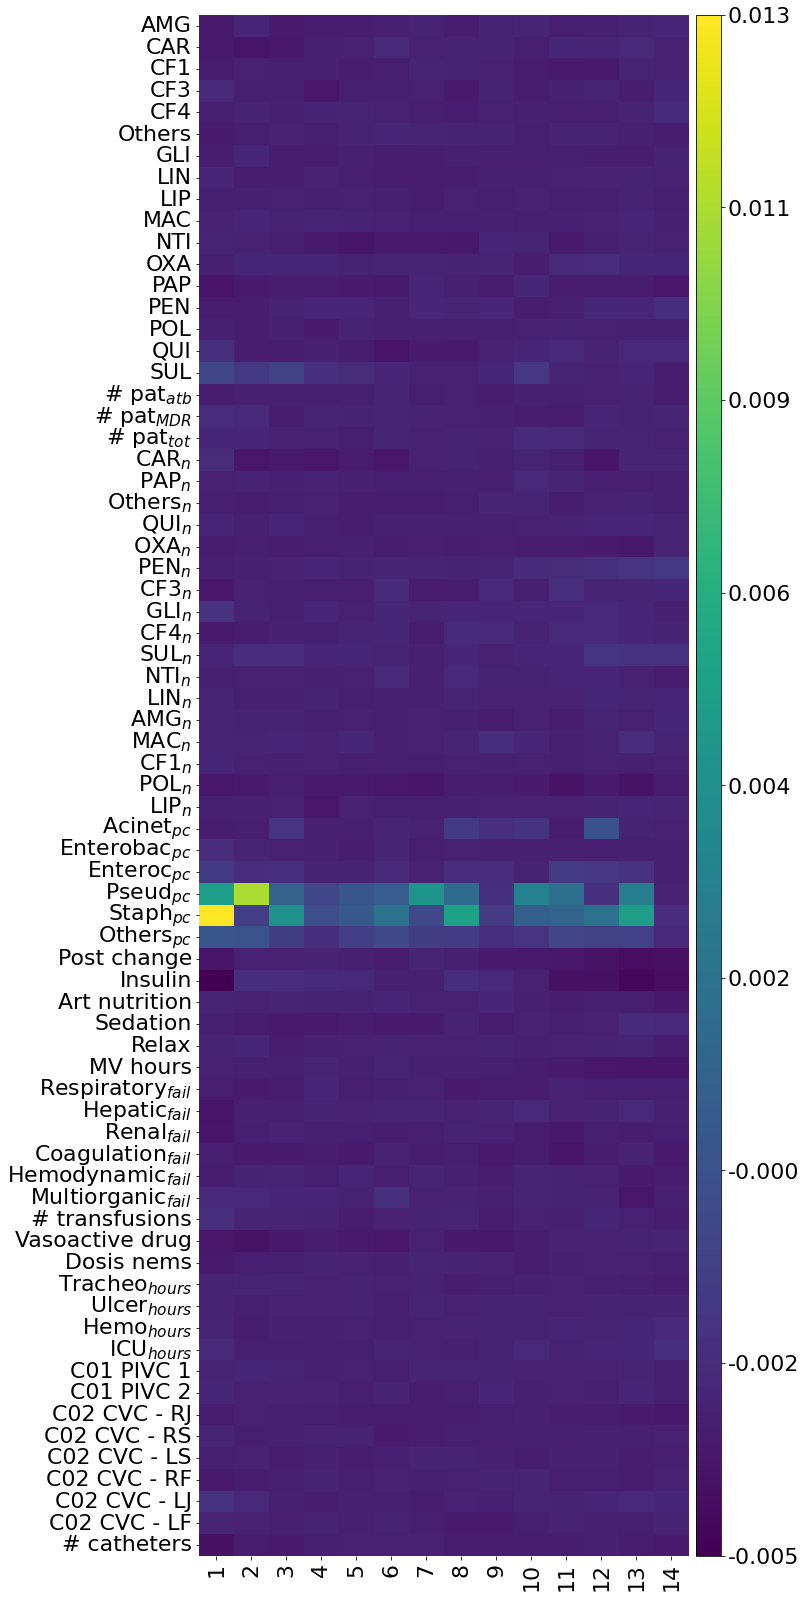

In [10]:
plot_shap_norm(matrix_pop, 
               matrix_amr, 
               reordered_indices, 
               f"../Figures_VF/SHAP_{split}_mdr.pdf", 
               save_img=True
) 

## NON MDR PATIENTS

In [11]:
split_shap_noamr = []

list_of_dfs = copy.deepcopy(split_shap)
array_pacientes = y_test_f

for i in range(len(list_of_dfs)):
    patient_shap = list_of_dfs[i]
    amr_status = array_pacientes[i]  

    for col in patient_shap.columns:
        if amr_status[col - 1] == 1: #AMR patients are set to Nan
            patient_shap.loc[:, col] = np.nan
        else:
            patient_shap.loc[:, col] = patient_shap.loc[:, col] #NonAMR patients keep the info

    split_shap_noamr.append(patient_shap)

**Visualize the Non MDR data without normalization**

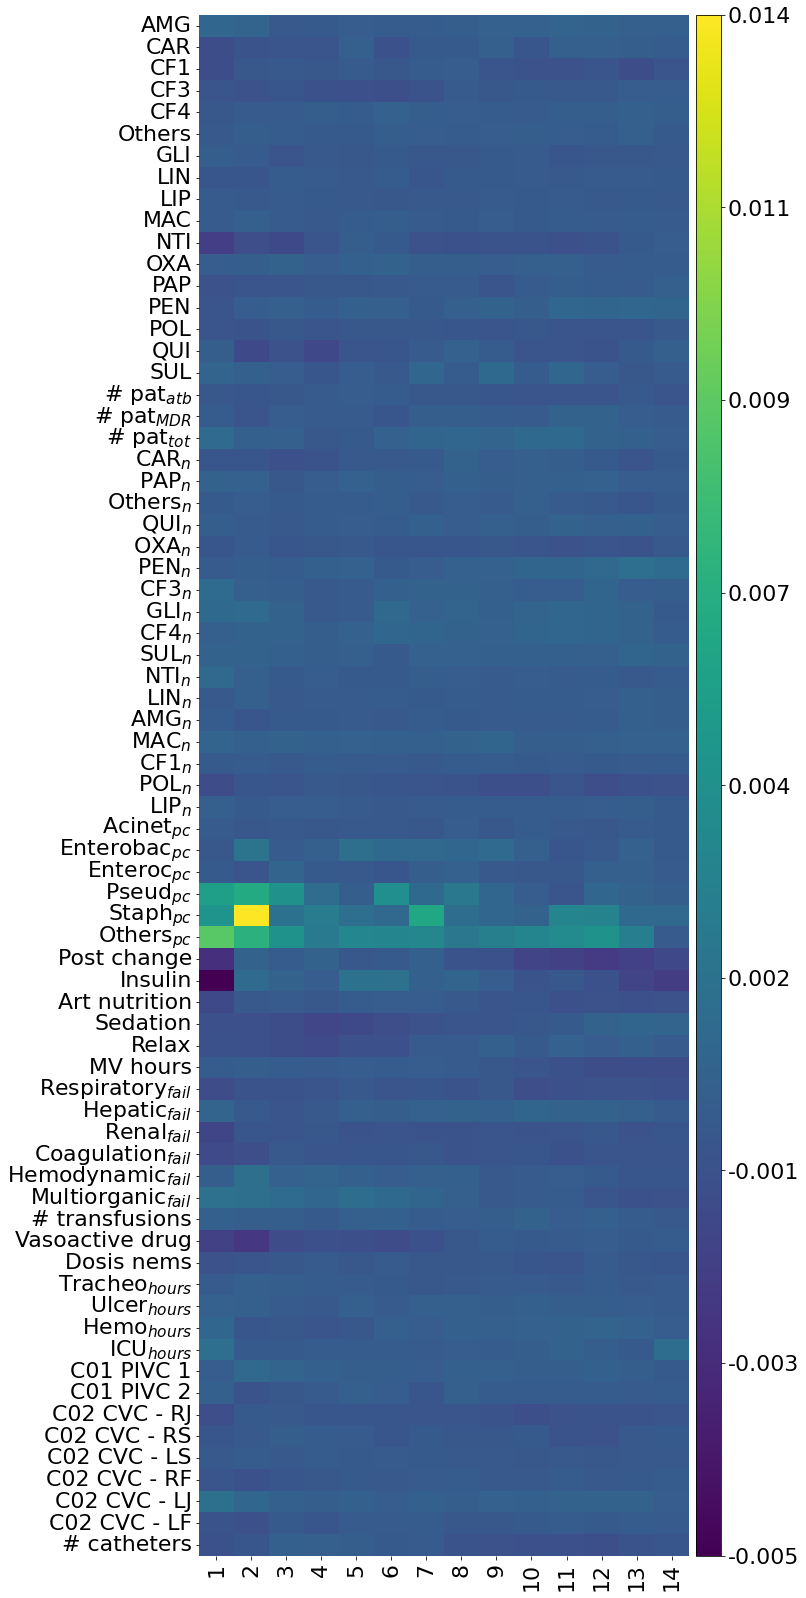

In [12]:
matrix_noamr = plot_shap(split_shap_noamr, reordered_indices, f" ", save_img=False)

**Visualize the Non MDR data with normalization**

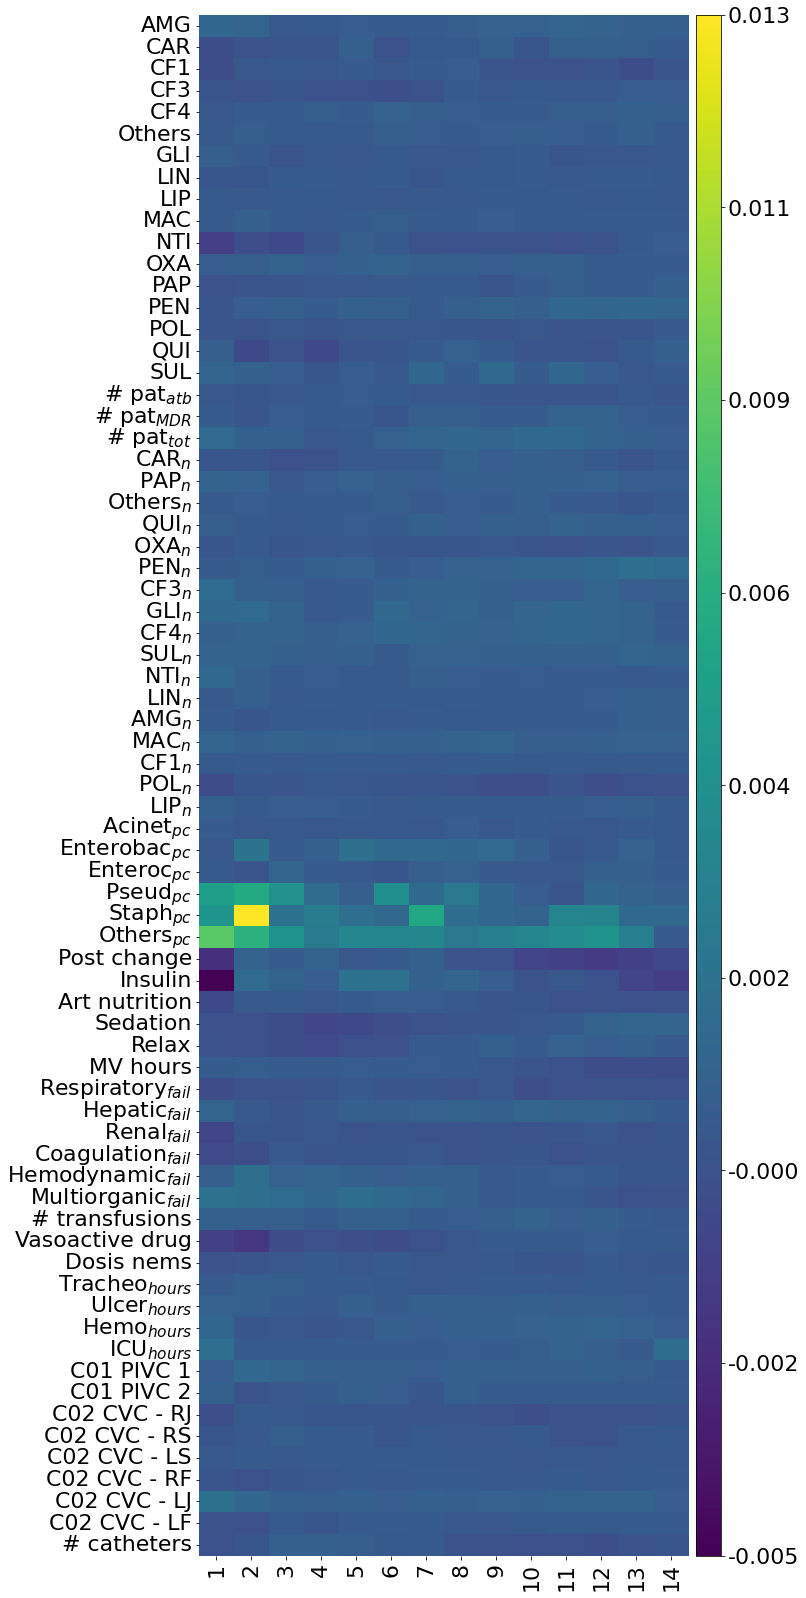

In [13]:
plot_shap_norm(matrix_pop, 
               matrix_noamr, 
               reordered_indices, 
               f"../Figures_VF/SHAP_{split}_nomdr.pdf", 
               save_img=True
) 

# SPLIT 2

In [14]:
directory = './Results_GRU'
split = "s2"
norm = "robustNorm"

### POPULATION

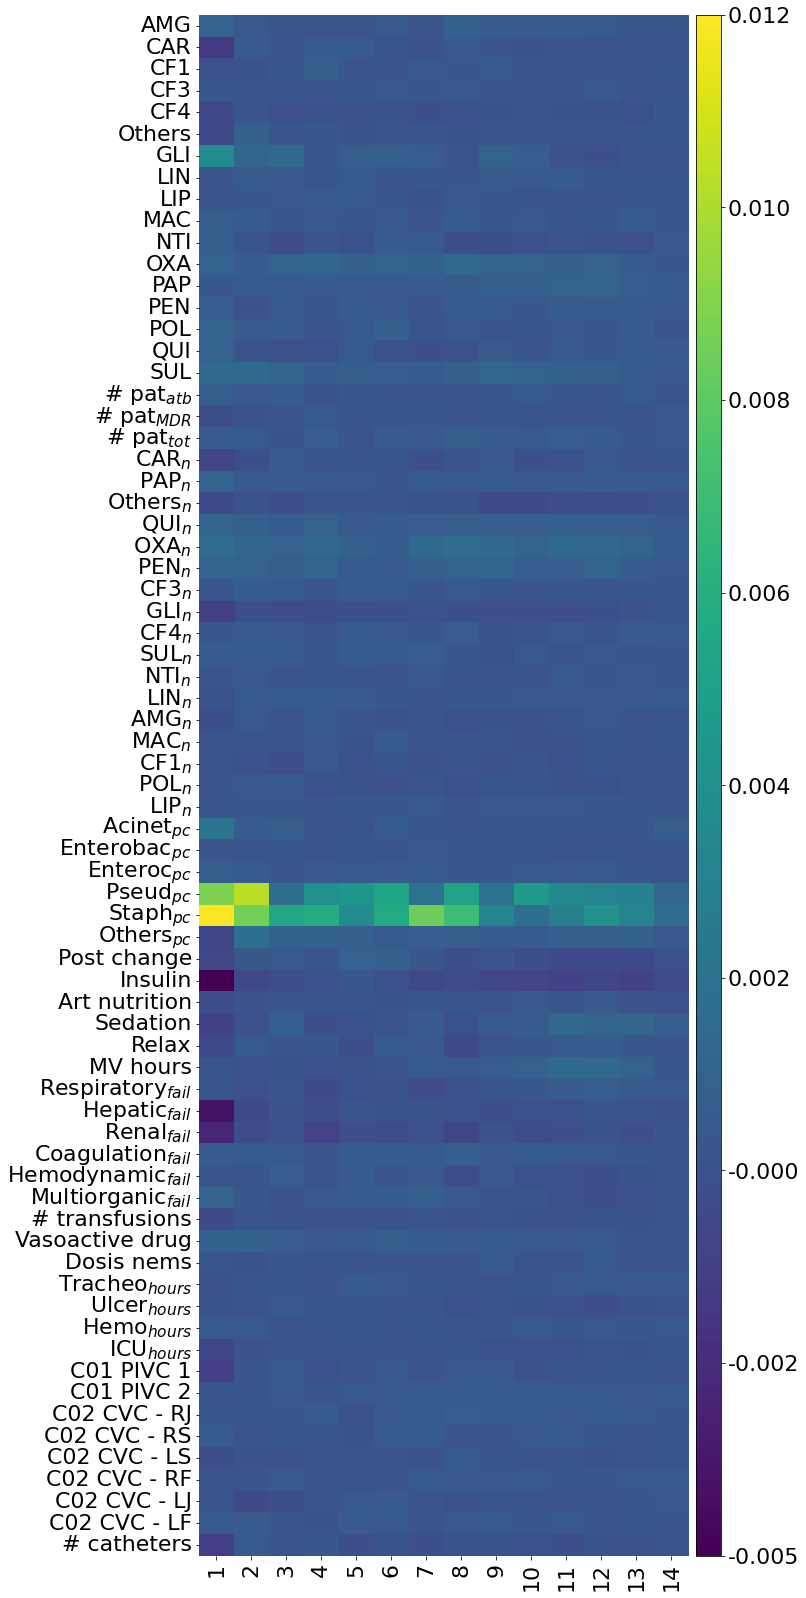

In [15]:
split_shap = load_from_pickle(os.path.join(directory, f"results_shap_{split}.pkl"))
matrix_pop = plot_shap(split_shap, reordered_indices, f"../Figures_VF/SHAP_{split}_population.pdf", save_img=True)

### MDR PATIENTS

In [16]:
ign_pat = []
X_test = np.load(f"../../DATA/BBCET_cult_ok_19062024/{split}/X_test_tensor_{norm}.npy")
for idx_pat in range(X_test.shape[0]):
    X = X_test[idx_pat]
    rows_filtered = np.any(X == 666, axis=-1)
    if len(rows_filtered[rows_filtered == False]) == 1:
        ign_pat.append(idx_pat)
        
y_test = pd.read_csv(f"../../DATA/BBCET_cult_ok_19062024/{split}/y_test_tensor_{norm}.csv")
y_test_f = y_test.loc[:, 'individualMRGerm'].values.reshape(y_test.shape[0] // n_time_steps, n_time_steps)
y_test_f = np.delete(y_test_f, ign_pat, axis=0)
y_test_f.shape

(1041, 14)

In [17]:
import copy

list_of_dfs = copy.deepcopy(split_shap)
array_pacientes = y_test_f

split_shap_amr = []

for i in range(len(list_of_dfs)):
    patient_shap = list_of_dfs[i]
    amr_status = array_pacientes[i]  

    for col in patient_shap.columns:
        if amr_status[col - 1] == 0:
            patient_shap.loc[:, col] = np.nan #NonAMR patients are set to Nan
        else:
            patient_shap.loc[:, col] = patient_shap.loc[:, col] #AMR patients keep the info

    split_shap_amr.append(patient_shap)


**Visualize the MDR data without normalization**

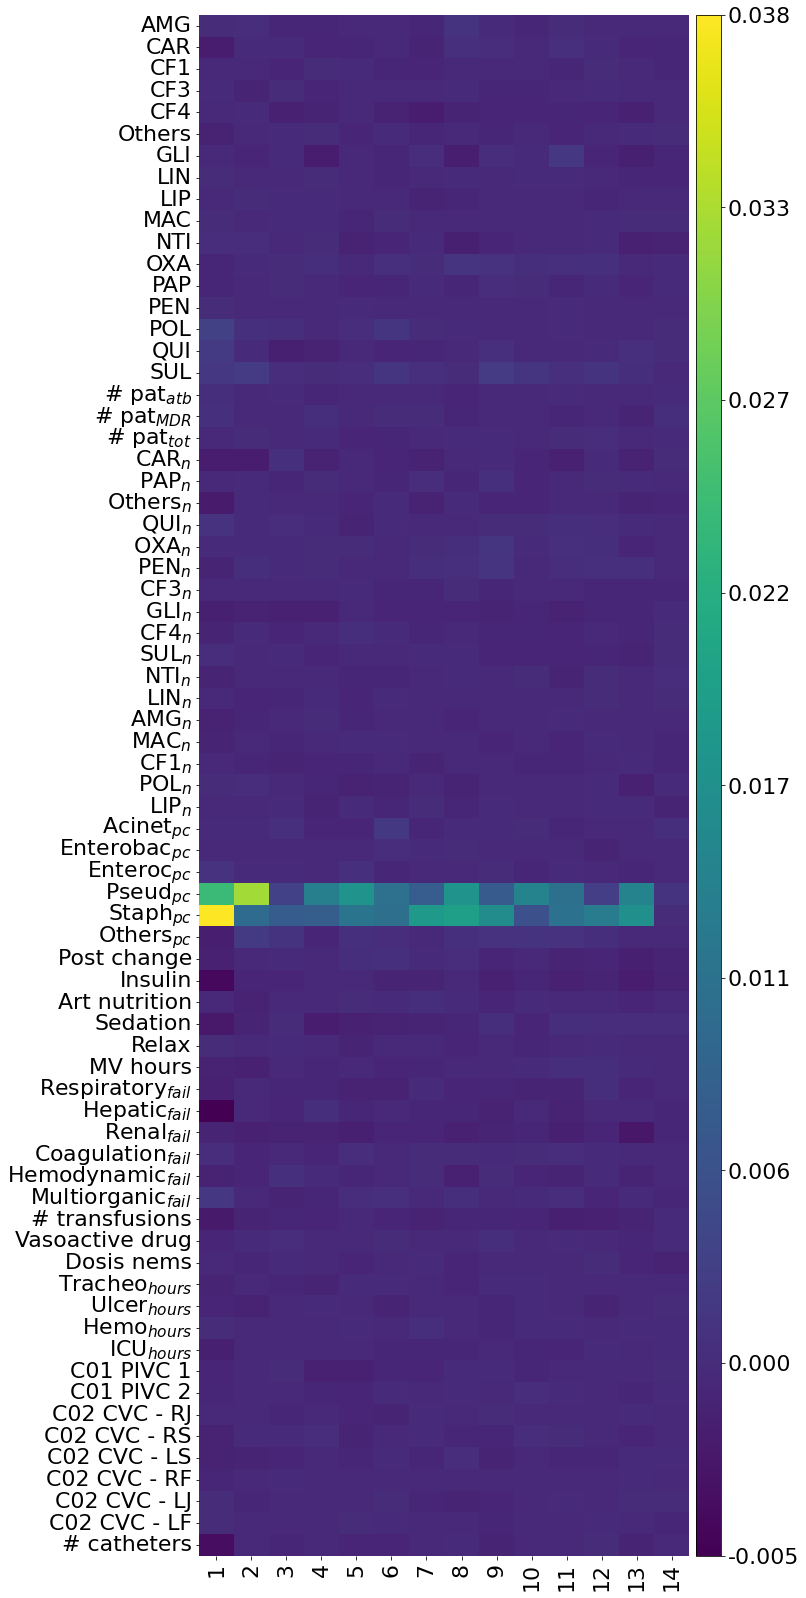

In [18]:
matrix_amr = plot_shap(split_shap_amr, reordered_indices, f"", save_img=False)

**Visualize the MDR data with normalization**

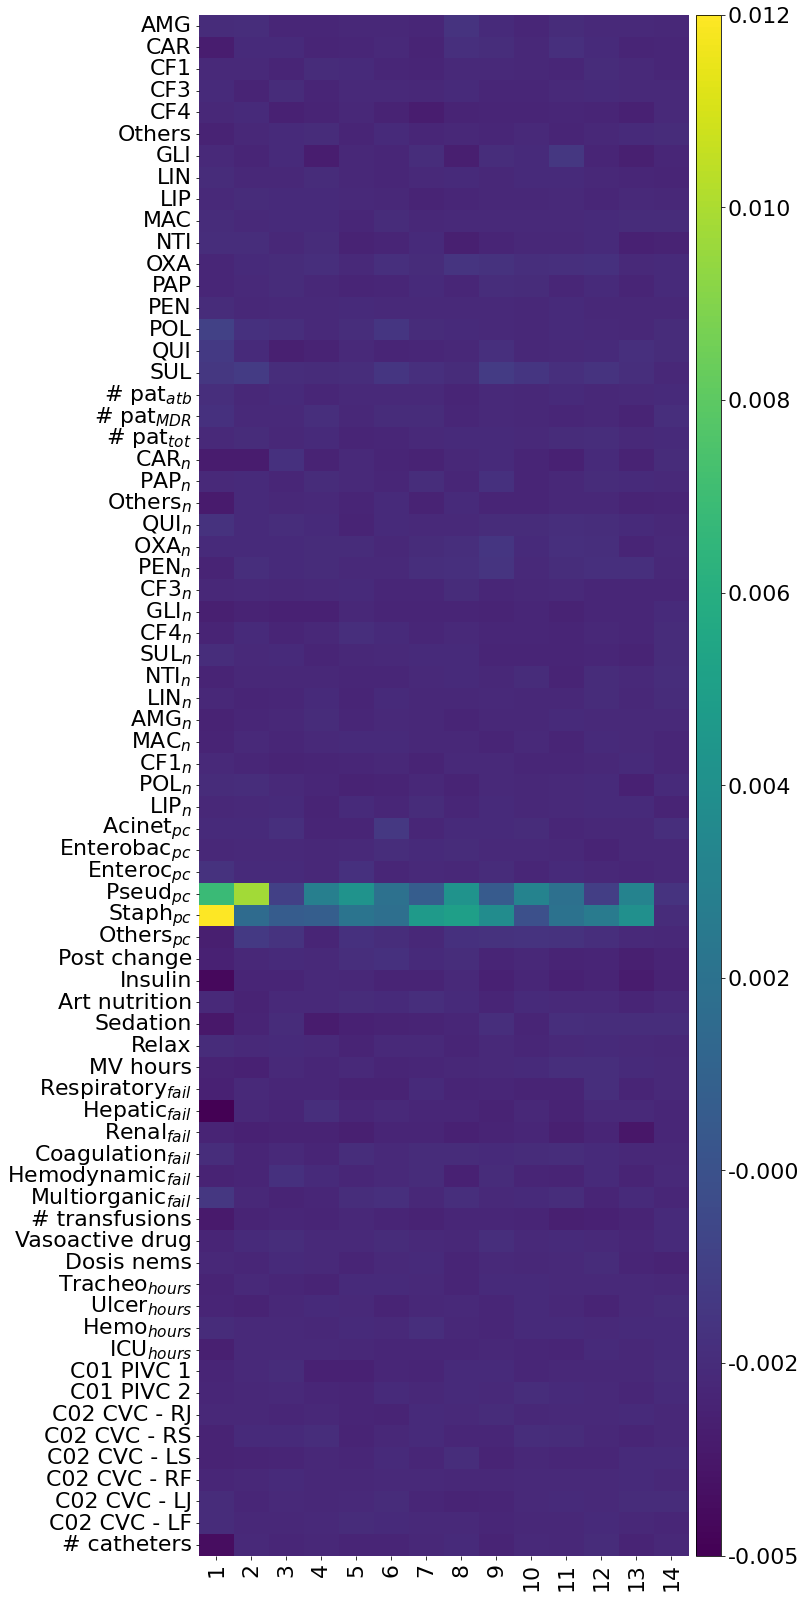

In [19]:
plot_shap_norm(matrix_pop, 
               matrix_amr, 
               reordered_indices, 
               f"../Figures_VF/SHAP_{split}_mdr.pdf", 
               save_img=True
) 

## NON MDR PATIENTS

In [20]:
split_shap_noamr = []

list_of_dfs = copy.deepcopy(split_shap)
array_pacientes = y_test_f

for i in range(len(list_of_dfs)):
    patient_shap = list_of_dfs[i]
    amr_status = array_pacientes[i]  

    for col in patient_shap.columns:
        if amr_status[col - 1] == 1: #AMR patients are set to Nan
            patient_shap.loc[:, col] = np.nan
        else:
            patient_shap.loc[:, col] = patient_shap.loc[:, col] #NonAMR patients keep the info

    split_shap_noamr.append(patient_shap)

**Visualize the Non MDR data without normalization**

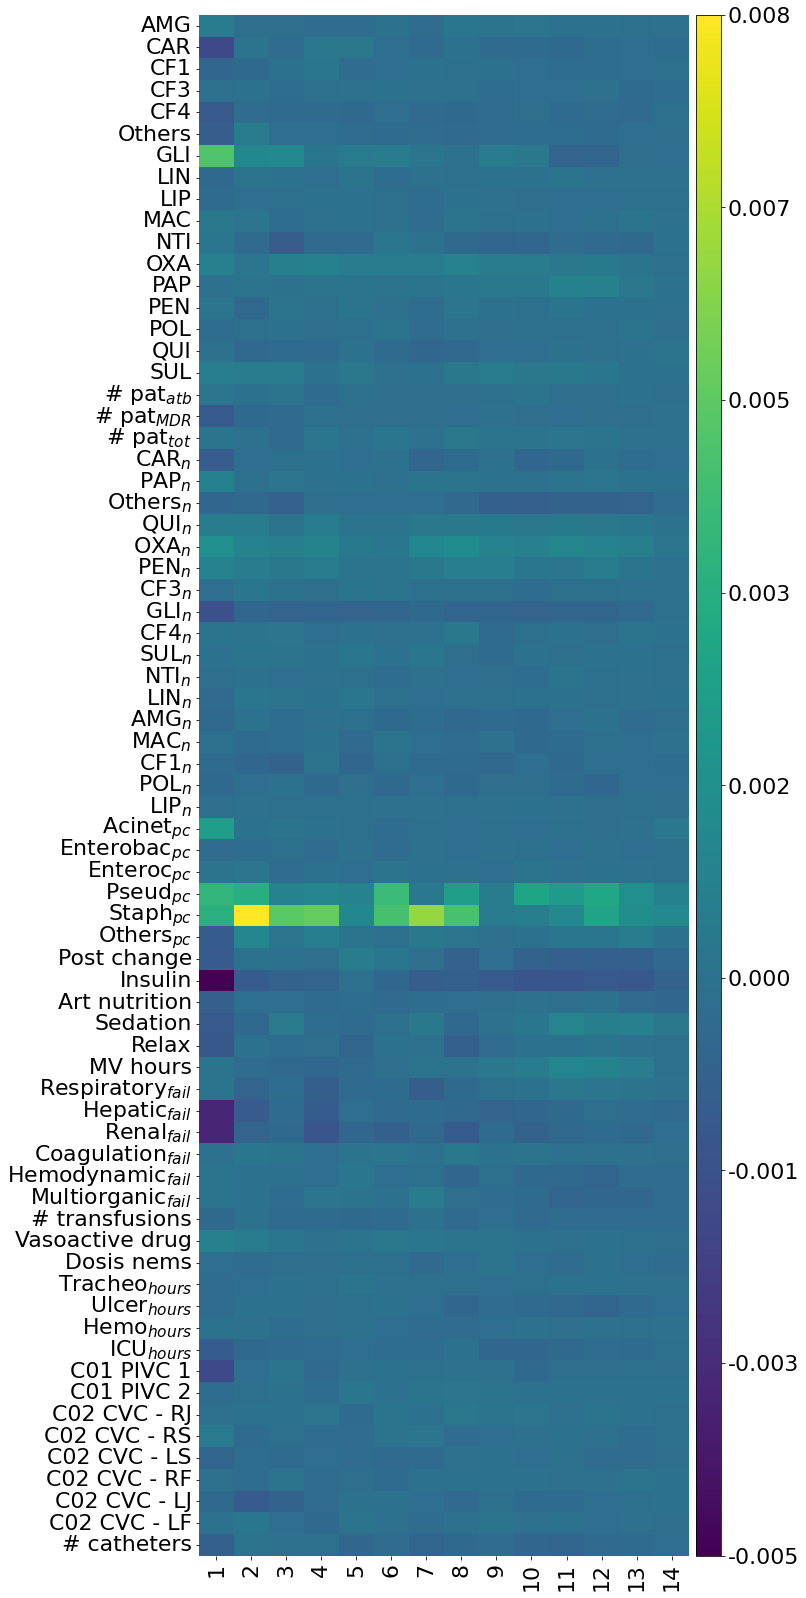

In [21]:
matrix_noamr = plot_shap(split_shap_noamr, reordered_indices, f" ", save_img=False)

**Visualize the Non MDR data with normalization**

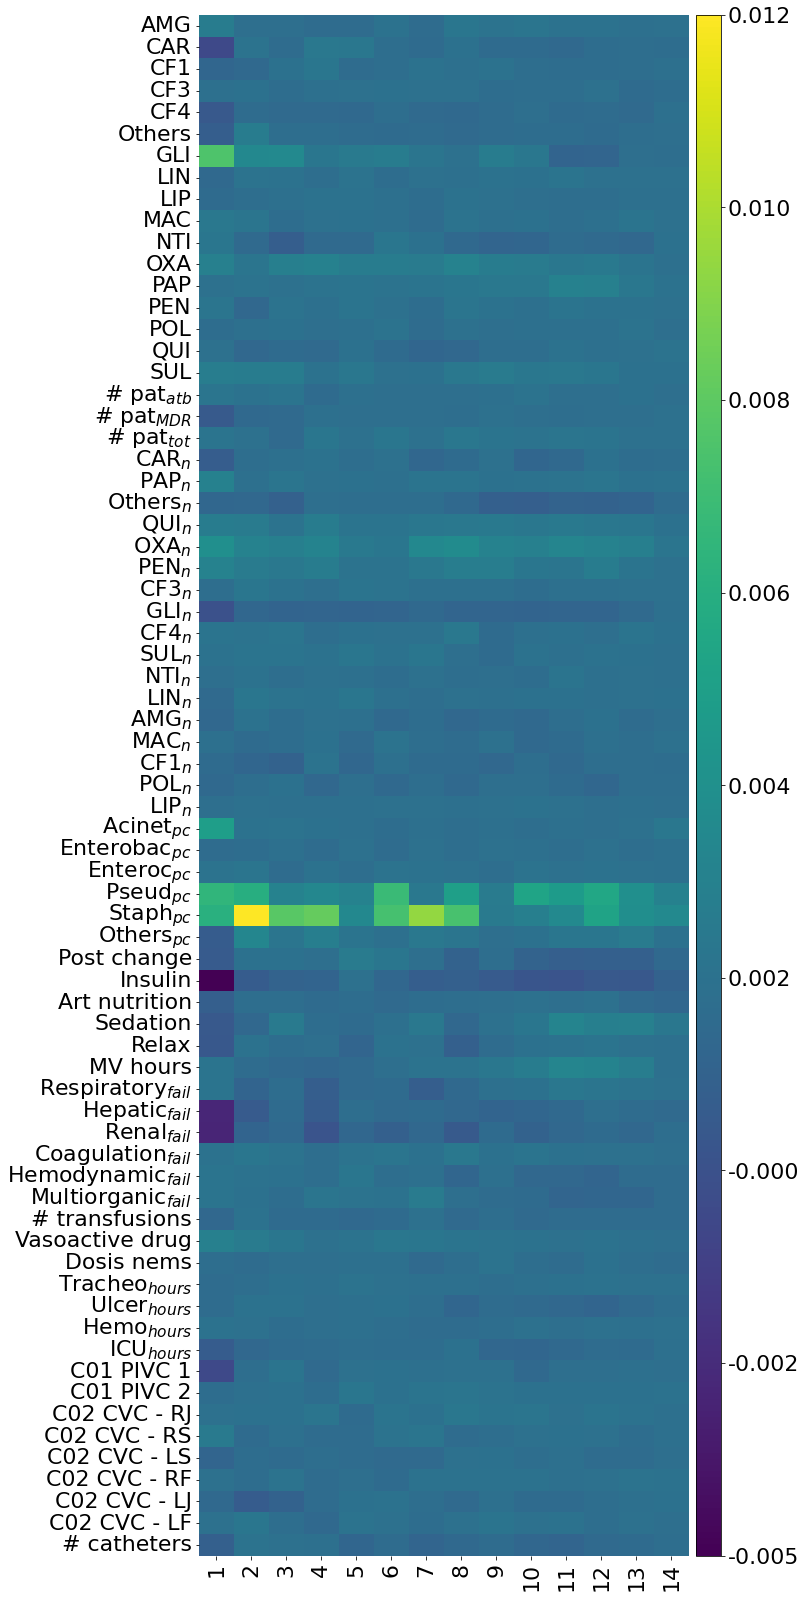

In [22]:
plot_shap_norm(matrix_pop, 
               matrix_noamr, 
               reordered_indices, 
               f"../Figures_VF/SHAP_{split}_nomdr.pdf", 
               save_img=True
) 

# SPLIT 3

In [23]:
directory = './Results_GRU'
split = "s3"
norm = "robustNorm"

### POPULATION

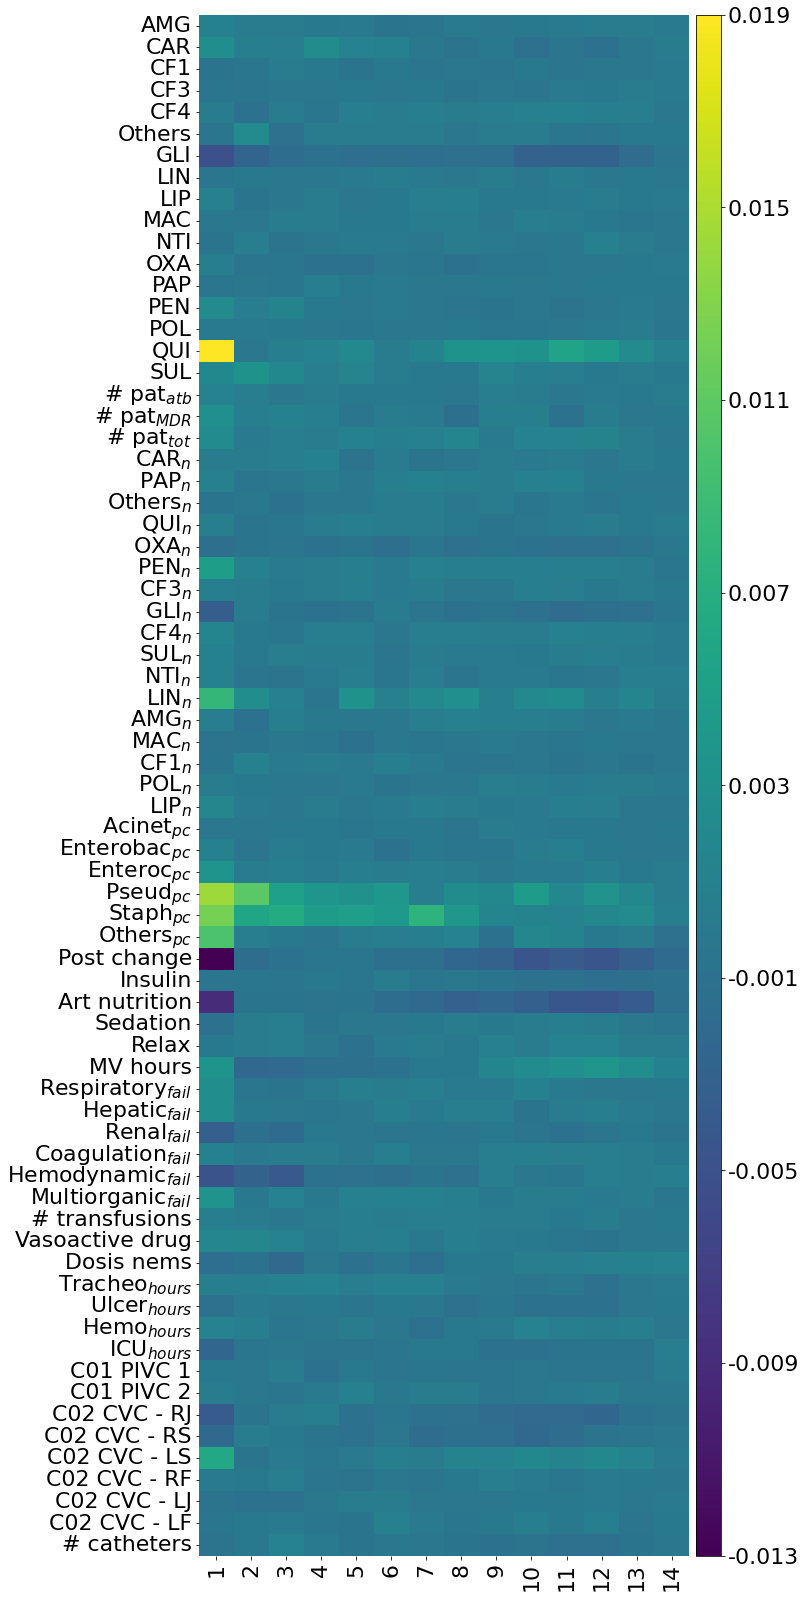

In [24]:
split_shap = load_from_pickle(os.path.join(directory, f"results_shap_{split}.pkl"))
matrix_pop = plot_shap(split_shap, reordered_indices, f"../Figures_VF/SHAP_{split}_population.pdf", save_img=True)

### MDR PATIENTS

In [25]:
ign_pat = []
X_test = np.load(f"../../DATA/BBCET_cult_ok_19062024/{split}/X_test_tensor_{norm}.npy")
for idx_pat in range(X_test.shape[0]):
    X = X_test[idx_pat]
    rows_filtered = np.any(X == 666, axis=-1)
    if len(rows_filtered[rows_filtered == False]) == 1:
        ign_pat.append(idx_pat)
        
y_test = pd.read_csv(f"../../DATA/BBCET_cult_ok_19062024/{split}/y_test_tensor_{norm}.csv")
y_test_f = y_test.loc[:, 'individualMRGerm'].values.reshape(y_test.shape[0] // n_time_steps, n_time_steps)
y_test_f = np.delete(y_test_f, ign_pat, axis=0)
y_test_f.shape

(1041, 14)

In [26]:
import copy

list_of_dfs = copy.deepcopy(split_shap)
array_pacientes = y_test_f

split_shap_amr = []

for i in range(len(list_of_dfs)):
    patient_shap = list_of_dfs[i]
    amr_status = array_pacientes[i]  

    for col in patient_shap.columns:
        if amr_status[col - 1] == 0:
            patient_shap.loc[:, col] = np.nan #NonAMR patients are set to Nan
        else:
            patient_shap.loc[:, col] = patient_shap.loc[:, col] #AMR patients keep the info

    split_shap_amr.append(patient_shap)


**Visualize the MDR data without normalization**

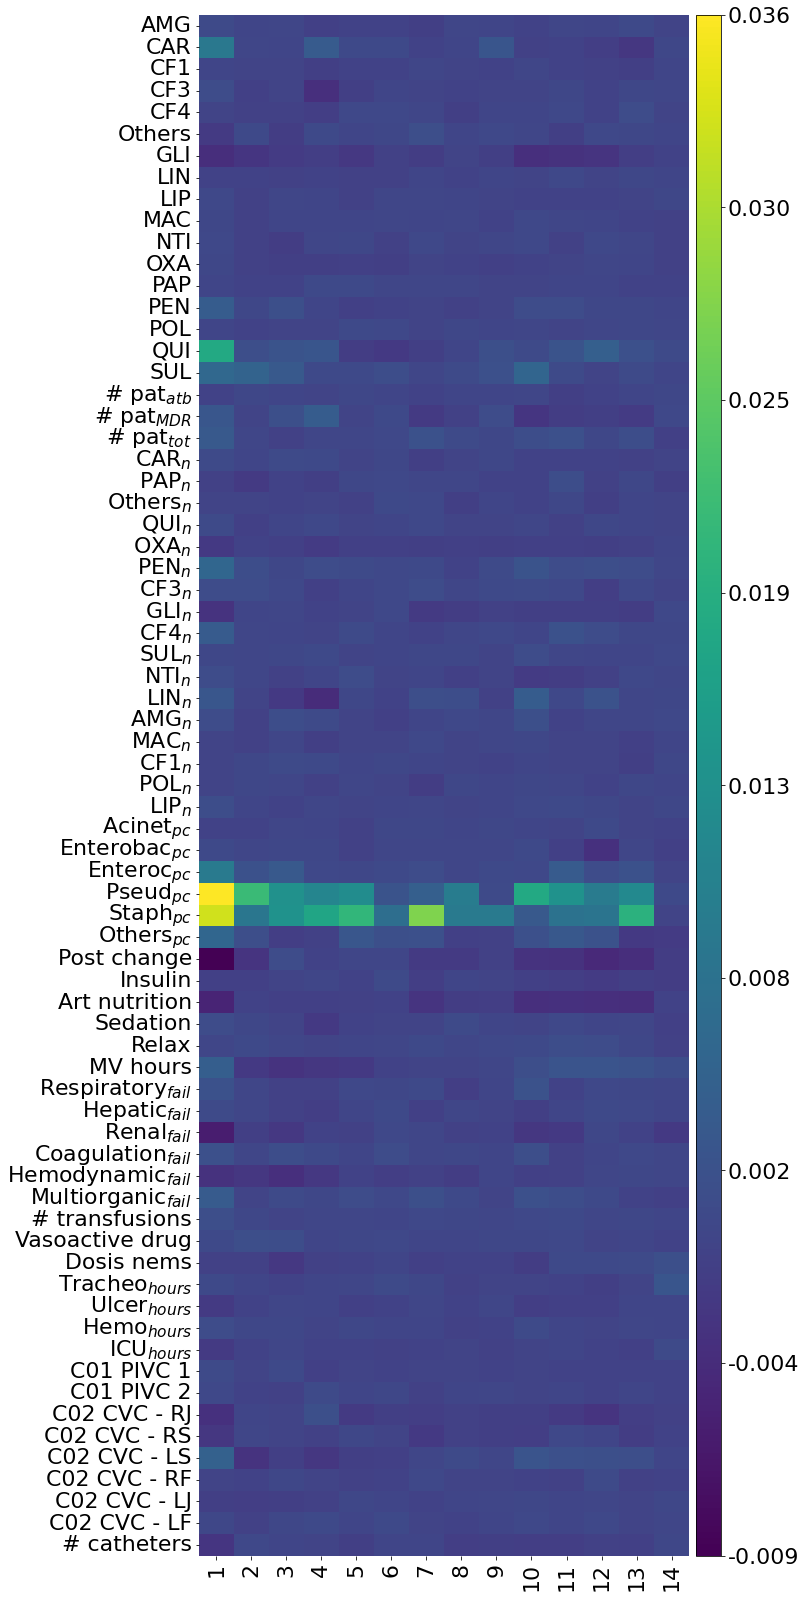

In [27]:
matrix_amr = plot_shap(split_shap_amr, reordered_indices, f"", save_img=False)

**Visualize the MDR data with normalization**

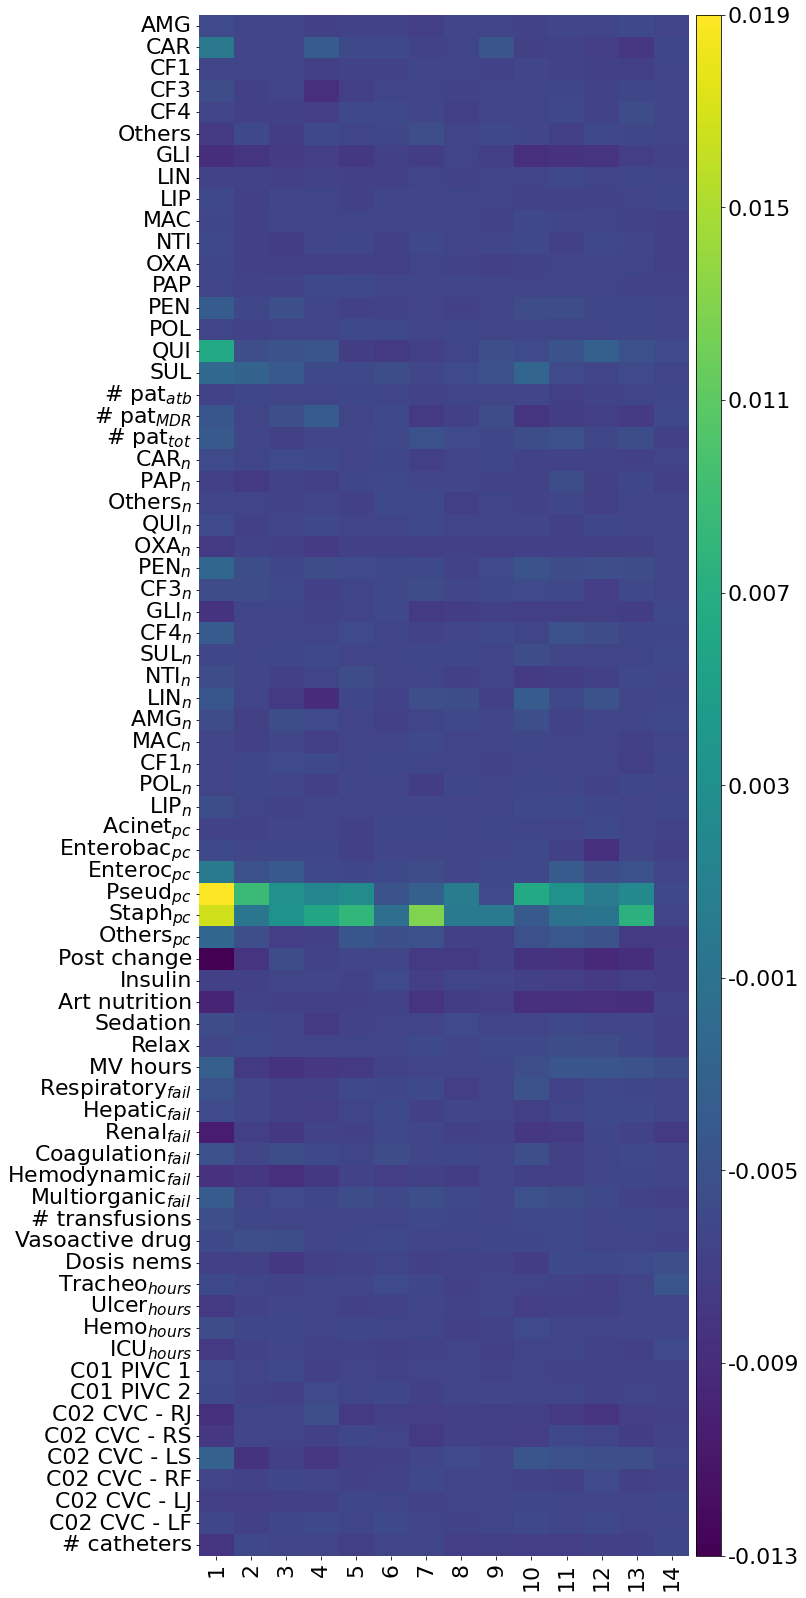

In [28]:
plot_shap_norm(matrix_pop, 
               matrix_amr, 
               reordered_indices, 
               f"../Figures_VF/SHAP_{split}_mdr.pdf", 
               save_img=True
) 

## NON MDR PATIENTS

In [29]:
split_shap_noamr = []

list_of_dfs = copy.deepcopy(split_shap)
array_pacientes = y_test_f

for i in range(len(list_of_dfs)):
    patient_shap = list_of_dfs[i]
    amr_status = array_pacientes[i]  

    for col in patient_shap.columns:
        if amr_status[col - 1] == 1: #AMR patients are set to Nan
            patient_shap.loc[:, col] = np.nan
        else:
            patient_shap.loc[:, col] = patient_shap.loc[:, col] #NonAMR patients keep the info

    split_shap_noamr.append(patient_shap)

**Visualize the Non MDR data without normalization**

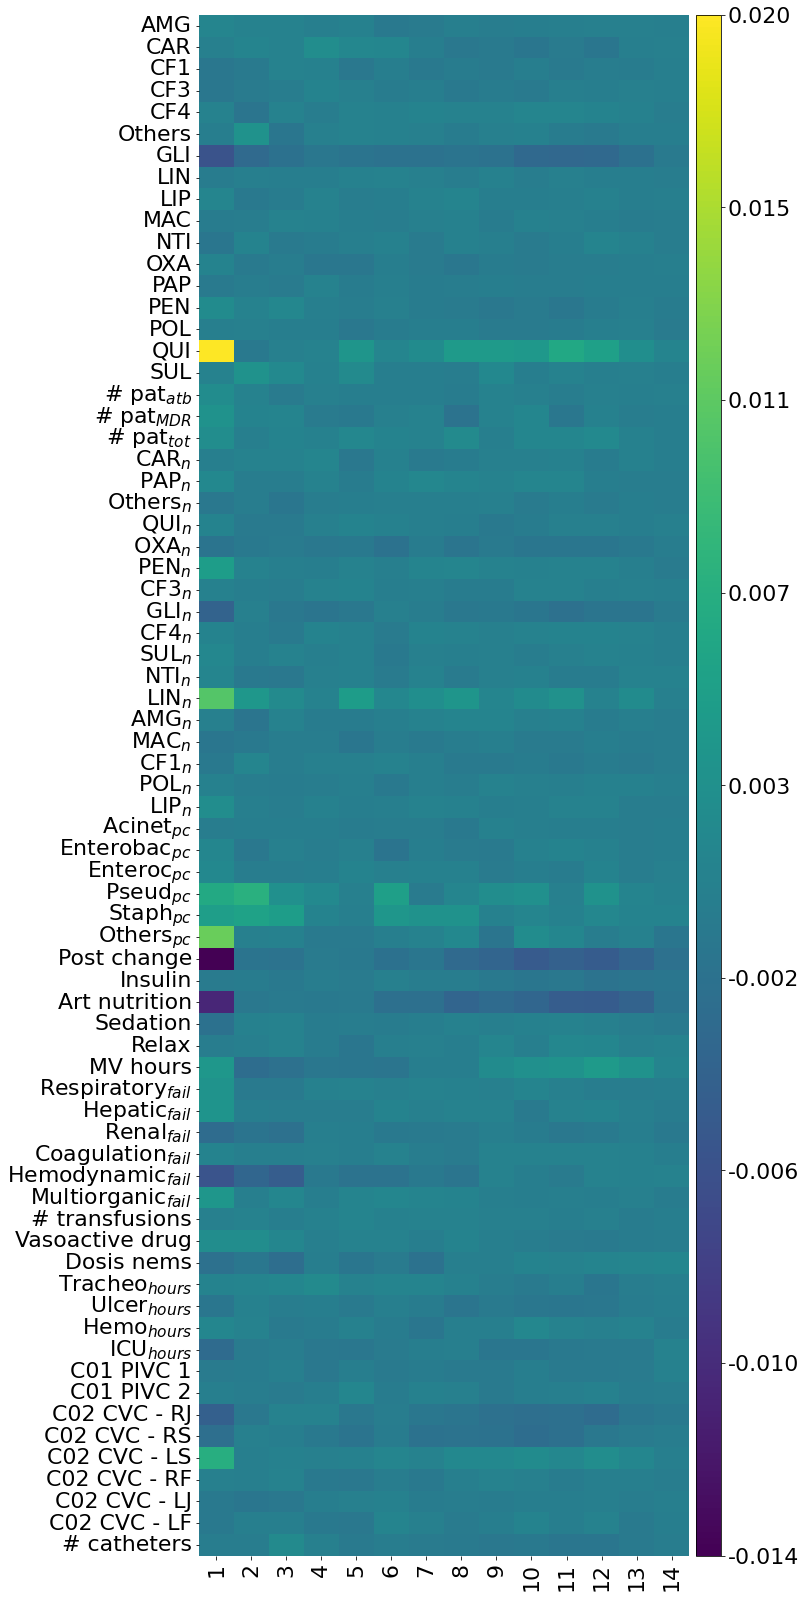

In [30]:
matrix_noamr = plot_shap(split_shap_noamr, reordered_indices, f" ", save_img=False)

**Visualize the Non MDR data with normalization**

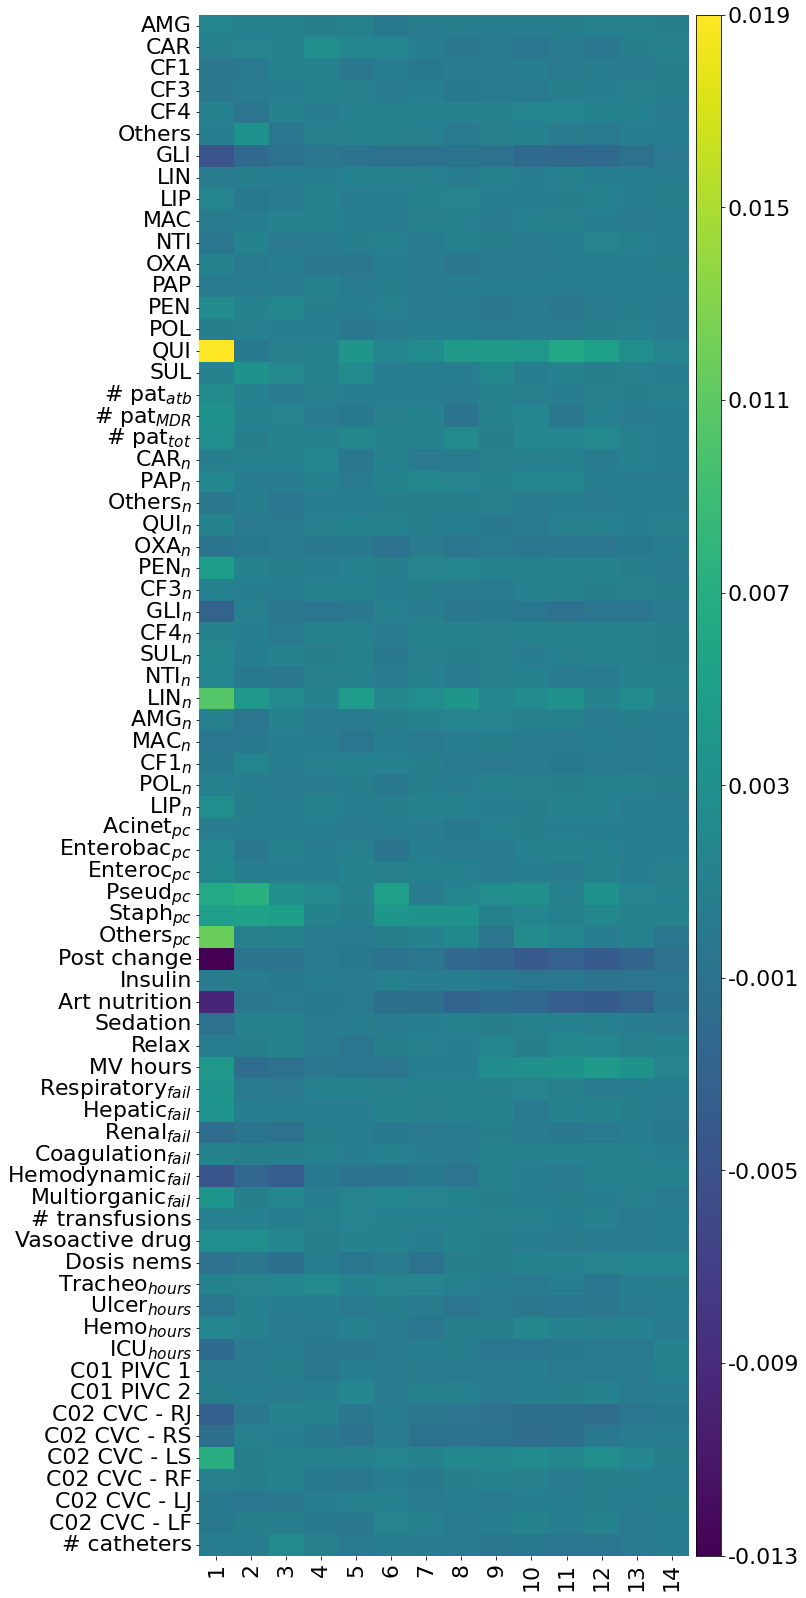

In [31]:
plot_shap_norm(matrix_pop, 
               matrix_noamr, 
               reordered_indices, 
               f"../Figures_VF/SHAP_{split}_nomdr.pdf", 
               save_img=True
) 